In [1]:
import numpy as np
import scipy
import sklearn
import matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import patsy

import scipy.stats as stats
import numpy.random as random
from tabulate import tabulate

import helper

In [2]:
# get package and versions
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.20.3
scipy==1.7.1
sklearn==0.23.2
matplotlib==3.3.3
pandas==1.2.2
seaborn==0.11.1
patsy==0.5.1


In [3]:
%matplotlib inline

In [4]:
# https://www.kaggle.com/andrewmvd/heart-failure-clinical-data
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [6]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


# EDA

### Single Variable

In [7]:
def outliers(df, col):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    return lower, upper

In [8]:
def remove_outliers(df, col, cond):
    
    # get upper and lower bound
    lower, upper = outliers(df, col)
    
    # diff before
    diff_before = df[(df[col] > upper) | (df[col] < lower)].shape[0]
    
    # rows before
    rows_before = df[col].shape[0]

    # filter
    df = df[(df[col] <= upper) & (df[col] >= lower)].copy()
    
    # rows after
    rows_after = df[col].shape[0]
    
    # rows removed
    diff_after = rows_before - rows_after
    assert (diff_after == diff_before), 'Diffs do not match!'
    
    return df, diff_after
    

def print_outlier_diff(df, df2, col):
    # print diff
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

    ax1.boxplot(df[col])
    ax1.set_title("Original")

    ax2.boxplot(df2[col])
    ax2.set_title("Outliers Removed")

    plt.show()
    plt.close()

    
def outlier_stats(df, df2, col):
    headers = ['Metric','Original', 'Filtered', '% Diff']
    stats = [['Mean',df[col].mean(), df2[col].mean(), df2[col].mean()/df[col].mean() - 1],
             ['Stdev',df[col].std(), df2[col].std(), df2[col].std()/df[col].std() - 1]]
    
    return stats, headers

In [9]:
def single_hist(data, col, bins=10, level='95'):
    fig, ax1 = plt.subplots(figsize=(15,8))
    mean = np.mean(data[col])
    median = np.median(data[col])    
    
    ax1.hist(data[col], density=True, alpha=0.8, bins=bins)
    ax1.axvline(mean, color='red')
    ax1.axvline(median, color='orange')
    if level == '99':
        lower_bound = stats.mstats.mquantiles(data[col], [0.1, 0.99])[0]
        upper_bound = stats.mstats.mquantiles(data[col], [0.1, 0.99])[1]
    elif level == '95':
        lower_bound = stats.mstats.mquantiles(data[col], [0.25, 0.975])[0]
        upper_bound = stats.mstats.mquantiles(data[col], [0.25, 0.975])[1]
    elif level == 'IQR':
        lower_bound, upper_bound = outliers(data, col)
    else:
        print("use a higher level")
    
    
    #ax1.axvline(, color='gold')
    #ax1.axvline(,  color='gold')
    ax1.axvspan(lower_bound, upper_bound, color='gold', alpha=0.15)
    ax1.set_title(col)
        
    plt.show()
    plt.close()

In [10]:
def histos(data, cols):
    
    features = len(cols)
    
    rows = features // 3
    
    for x in range(rows):
        
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, rows))
        
        num = x*3
        g = data[cols[num]]
        mean = np.mean(g)
        lower_bound, upper_bound = outliers(data, cols[num])
        ax1.hist(data[cols[num]], density=True, alpha=0.8)
        ax1.axvspan(lower_bound, upper_bound, color='gold', alpha=0.1)
        ax1.axvline(mean, color='red')
        ax1.set_title(cols[num])
        
        num += 1
        g = data[cols[num]]
        mean = np.mean(g)
        lower_bound, upper_bound = outliers(data, cols[num])
        ax2.hist(data[cols[num]], density=True, alpha=0.8)
        ax2.axvspan(lower_bound, upper_bound, color='gold', alpha=0.1)
        ax2.set_title(cols[num])
        ax2.axvline(mean, color='red')
        
        num += 1
        g = data[cols[num]]
        mean = np.mean(g)
        lower_bound, upper_bound = outliers(data, cols[num])
        ax3.hist(data[cols[num]], density=True, alpha=0.8)
        ax3.axvspan(lower_bound, upper_bound, color='gold', alpha=0.1)
        ax3.set_title(cols[num])
        ax3.axvline(mean, color='red')
    
    plt.show()
    plt.close()

In [11]:
def boxes(data, cols):
    features = len(cols)
    
    rows = features // 3
    
    for x in range(rows):
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, rows))
        
        num = x*3
        g = data[cols[num]]
        mean = np.mean(g)
        ax1.boxplot(data[cols[num]])
        ax1.set_title(cols[num])
        
        num += 1
        g = data[cols[num]]
        mean = np.mean(g)
        ax2.boxplot(data[cols[num]])
        ax2.set_title(cols[num])
        
        num += 1
        g = data[cols[num]]
        mean = np.mean(g)
        ax3.boxplot(data[cols[num]])
        ax3.set_title(cols[num])
    
    plt.show()
    plt.close()

In [12]:
cols = df.keys()
cols = cols.drop('DEATH_EVENT')

cols = list(cols)

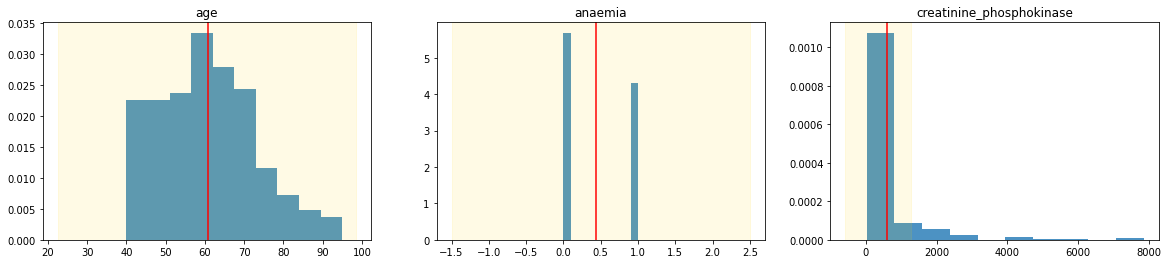

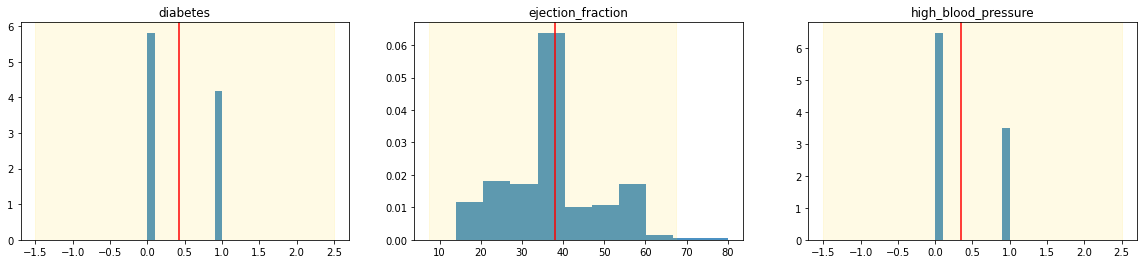

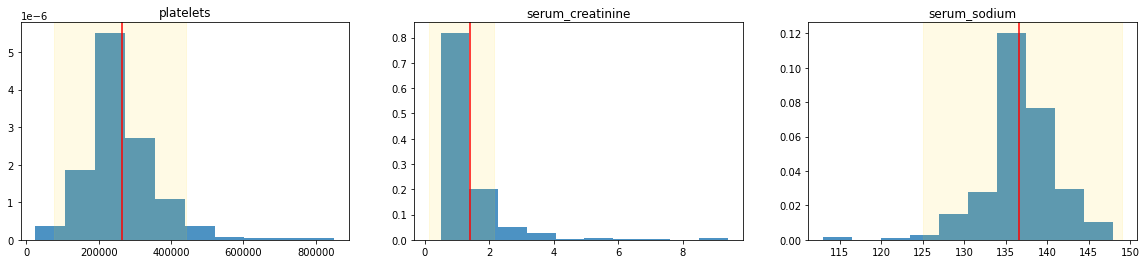

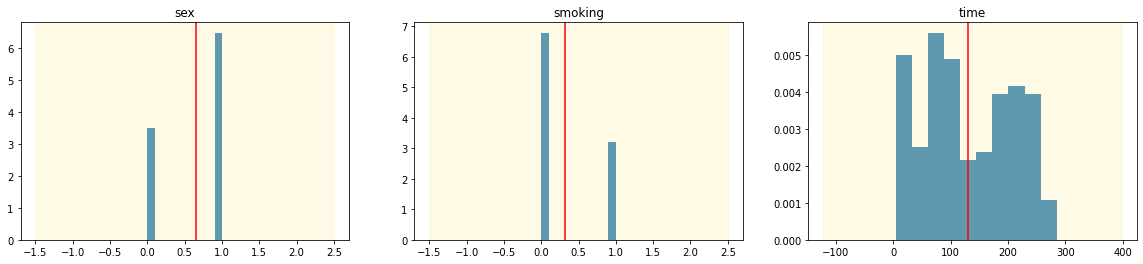

In [13]:
histos(df,cols)

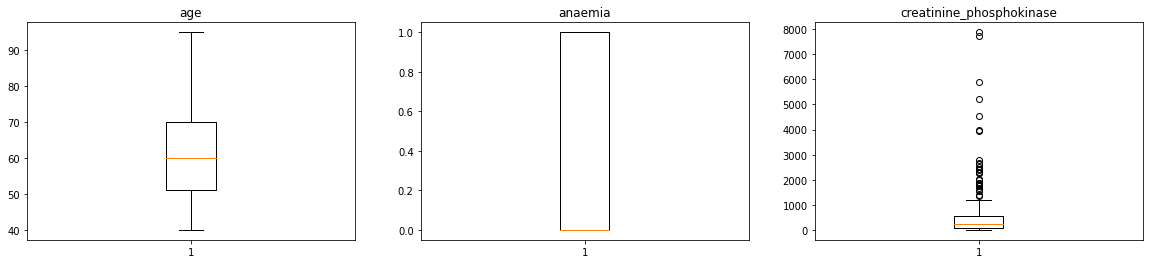

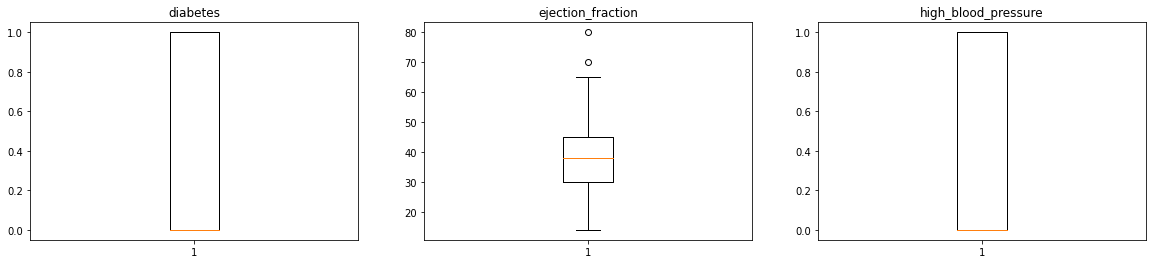

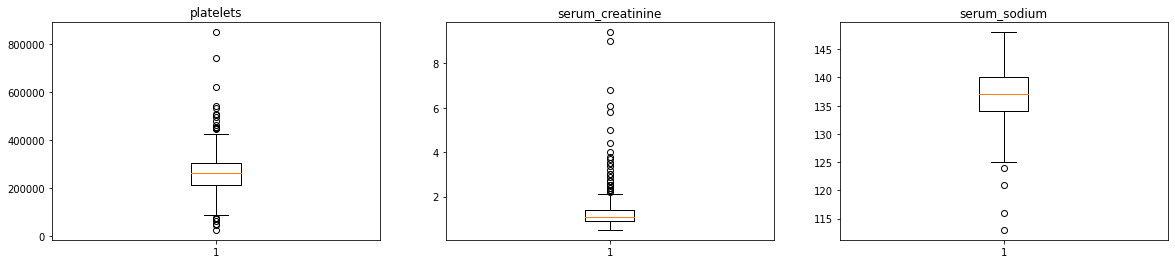

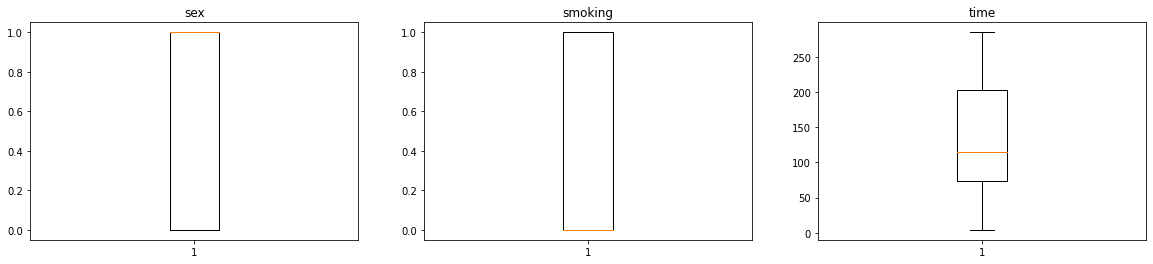

In [14]:
boxes(df, cols)

I only see outliers in the biomarkers

Note: matplotlib boxplot whiskers only go do highest/lowest data point and do not extend to the full range (Q1/3 $\pm$ 1.5*IRQ)

we see some variables are only binary/categorical lets define those groups and look at an outlier graph

In [15]:
# create variable for category variables
cols_cat = ['anaemia', 'diabetes','high_blood_pressure', 'sex', 'smoking']

In [16]:
# create variable for numeric
cols_num = [x for x in cols if x not in cols_cat]

In [17]:
df.serum_creatinine.describe().to_frame()

,serum_creatinine
count,299.00000
mean,1.39388
std,1.03451
min,0.50000
25%,0.90000
50%,1.10000
75%,1.40000
max,9.40000


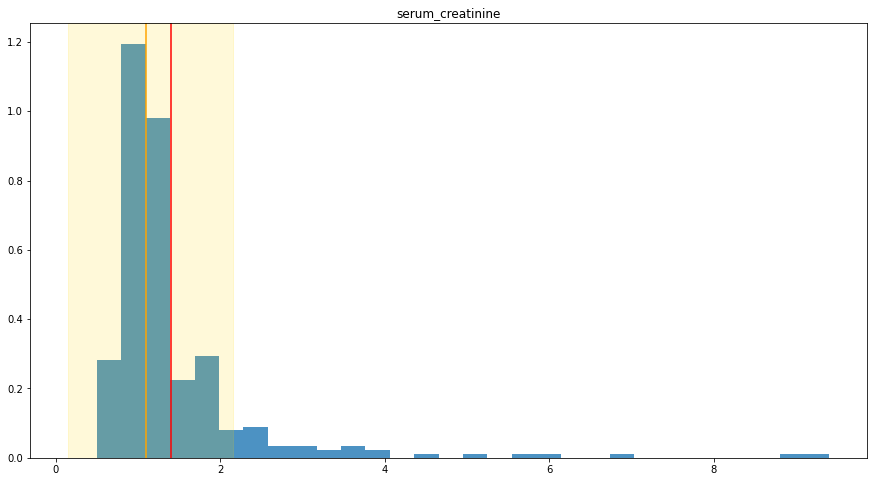

In [18]:
single_hist(df, 'serum_creatinine', bins=30, level='IQR')

In [19]:
lower1, upper1 = outliers(df, 'serum_creatinine')
lower2, upper2 = outliers(df, 'creatinine_phosphokinase')
lower3, upper3 = outliers(df, 'serum_sodium')

In [20]:
cond1 = ((df['serum_creatinine'] > upper1) | (df['serum_creatinine'] < lower1))
cond2 = ((df['creatinine_phosphokinase'] > upper2) | (df['creatinine_phosphokinase'] < lower2))
cond3 = ((df['serum_sodium'] > upper3) | (df['serum_sodium'] < lower3))

In [21]:
print(df[cond1].shape[0])
print(df[cond1 & cond2].shape[0])
print(df[cond1 & cond2 & cond3].shape[0])

29
2
0


Interesting, there are 2 records of the 29 where they match outlieres in other variables. Lets take a look

In [22]:
# get lower values
df[df['serum_creatinine'] < lower1]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT


In [23]:
# get upper values
df[df['serum_creatinine'] > upper1].reset_index()

,index,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
1,9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1,10,1
2,10,75.0,1,81,0,38,1,368000.00,4.0,131,1,1,10,1
3,28,58.0,1,60,0,38,0,153000.00,5.8,134,1,0,26,1
4,31,85.0,0,23,0,45,0,360000.00,3.0,132,1,0,28,1
5,35,69.0,0,582,1,35,0,228000.00,3.5,134,1,0,30,1
6,38,60.0,0,2656,1,30,0,305000.00,2.3,137,1,0,30,0
7,39,60.0,0,235,1,38,0,329000.00,3.0,142,0,0,30,1
8,48,80.0,1,553,0,20,1,140000.00,4.4,133,1,0,41,1
9,52,60.0,0,3964,1,62,0,263358.03,6.8,146,0,0,43,1


In [24]:
df[cond1 & cond2]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
38,60.0,0,2656,1,30,0,305000.00,2.3,137,1,0,30,0
52,60.0,0,3964,1,62,0,263358.03,6.8,146,0,0,43,1


In [25]:
df[cond1 & cond2 & cond3]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT


We see that of the 29 outliers there are only 2 outliers that are outliers in the 2 other variables/biomarkers. Those 2 should be super safer to remove, but then again its only 2 records, not sure if its worth it. 

We could save this for the transform section and make a two copies of the data, but for now lets move on with the original data.

In [26]:
#df_filtered, rows_removed = remove_outliers(df, 'serum_creatinine')
#print(rows_removed)

In [27]:
#print_outlier_diff(df,df_filtered, 'serum_creatinine')

In [28]:
#stats, headers = outlier_stats(df,df_filtered, 'serum_creatinine')

#tabulate(stats, headers=headers, tablefmt='html')

### Pairwise

Here I'll look at 2 variables together to get a sense of their interactions. Mostly how they correlate to the DEATH_EVENT our target variable

In [29]:
def correlation(data, x, y):
    res = []
    pr = stats.pearsonr(data[x], data[y])[0]
    sr = stats.spearmanr(data[x], data[y])[0]
    res.append(pr)
    res.append(sr)
    #print('Pearson r:\t', pr)
    #print('Spearman ro:\t', sr)
    return res

def all_corrs(df, columns):
    res = []
    for x in cols:
        correlations = correlation(df, x, 'DEATH_EVENT')
        new_list = []
        new_list.append(x)
        # merge two lists
        new_list.extend(correlations)
        # append new list to results
        res.append(new_list)

    res = pd.DataFrame(res, columns=['feature', 'pearson (r)', 'spearman'])
    return res.sort_values(by='pearson (r)', ascending=False)

In [30]:
from IPython.display import display

for x in cols_cat:
    display(pd.crosstab(df[x], df['DEATH_EVENT'], margins=True))

DEATH_EVENT,0,1,All
anaemia,,,
0,120,50,170
1,83,46,129
All,203,96,299


DEATH_EVENT,0,1,All
diabetes,,,
0,118,56,174
1,85,40,125
All,203,96,299


DEATH_EVENT,0,1,All
high_blood_pressure,,,
0,137,57,194
1,66,39,105
All,203,96,299


DEATH_EVENT,0,1,All
sex,,,
0,71,34,105
1,132,62,194
All,203,96,299


DEATH_EVENT,0,1,All
smoking,,,
0,137,66,203
1,66,30,96
All,203,96,299


Interesting, not sure this helps much but ok. Lets look at correlations

In [31]:
all_corrs(df, cols)

,feature,pearson (r),spearman
7,serum_creatinine,0.294278,0.370630
0,age,0.253729,0.218125
5,high_blood_pressure,0.079351,0.079351
1,anaemia,0.066270,0.066270
2,creatinine_phosphokinase,0.062728,0.023616
3,diabetes,-0.001943,-0.001943
9,sex,-0.004316,-0.004316
10,smoking,-0.012623,-0.012623
6,platelets,-0.049139,-0.046200
8,serum_sodium,-0.195204,-0.209837


In [32]:
# I just found out you could do this...
df.corr()['DEATH_EVENT']

age                         0.253729
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
ejection_fraction          -0.268603
high_blood_pressure         0.079351
platelets                  -0.049139
serum_creatinine            0.294278
serum_sodium               -0.195204
sex                        -0.004316
smoking                    -0.012623
time                       -0.526964
DEATH_EVENT                 1.000000
Name: DEATH_EVENT, dtype: float64

In [33]:
# lets get the biggest difference makers
df.corr()[abs(df.corr()['DEATH_EVENT']) > 0.1]['DEATH_EVENT']

age                  0.253729
ejection_fraction   -0.268603
serum_creatinine     0.294278
serum_sodium        -0.195204
time                -0.526964
DEATH_EVENT          1.000000
Name: DEATH_EVENT, dtype: float64

We can see serum_creatinine has the highest correlation to the death rate. 

Lets run normal linear regression on each pair to see the coefficents. We know linear regression on a classification dataset (DEATH_EVENT = {0, 1}) is misleading and is susceptible to outliers but lets take a look anyway.

In [34]:
from numpy.polynomial import Polynomial

def plot_regression(df, col):
    # create xs
    line_x = np.linspace(df[col].min(), df[col].max(), 10)

#     # legacy 
#     fit = np.polyfit(df[col], df['DEATH_EVENT'],1) 
#     # create polynomial object and pass in coef
#     line = np.poly1d(fit)
#     # evaluate line at every line_x to make ys
#     line_y = list(map(line, line_x))

    # new
    fit = Polynomial.fit(df[col], df['DEATH_EVENT'], 1)
    # create polynomial object and pass in coef from series
    p = Polynomial(fit.convert().coef)
    #line_y = list(map(p, line_x))       # option 1, pass in poly object
    line_y = list(map(fit, line_x))     # option 2, pass in series object

    fig, ax = plt.subplots()

    ax.scatter(df[col], df.DEATH_EVENT)
    ax.plot(line_x, line_y, color='red')
    ax.set_title(col)

    print(f'Reg Line for {col}: {p}')
    plt.show()
    plt.close()

def get_coefs(df, cols):
    res = []
    for x in cols:
        coefs = []
        # create xs
        line_x = np.linspace(df[x].min(), df[x].max(), 10)

        # new
        fit = Polynomial.fit(df[x], df['DEATH_EVENT'], 1)
        # create polynomial object and pass in coef from series
        p = Polynomial(fit.convert().coef)
        
        coefs.append(x)
        coefs.append(p.coef[0])
        coefs.append(p.coef[1])
        res.append(coefs)
    
    
    #res = list(zip(cols, res))
    return res    

Reg Line for age: -0.28580214117333613 + 0.009975892476922332 x**1


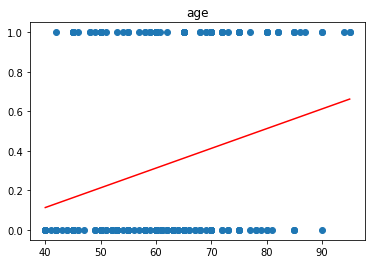

Reg Line for creatinine_phosphokinase: 0.30347864681471776 + 3.023443468643732e-05 x**1


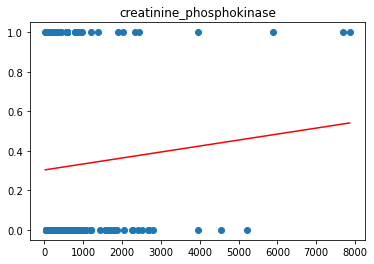

Reg Line for ejection_fraction: 0.7252987876378196 - 0.010614238825301485 x**1


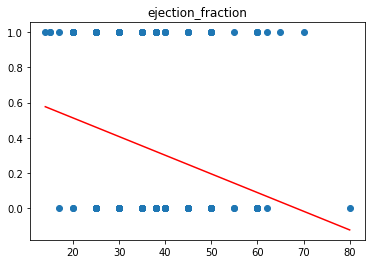

Reg Line for platelets: 0.3829507536821339 - 2.3496727911166046e-07 x**1


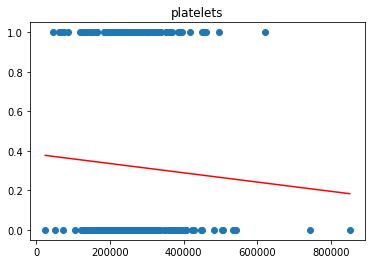

Reg Line for serum_creatinine: 0.13563698891294285 + 0.13303390434779402 x**1


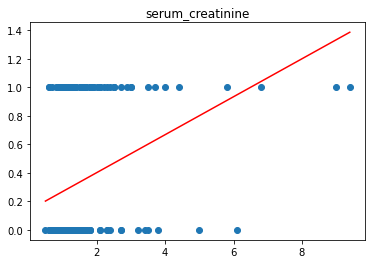

Reg Line for serum_sodium: 3.147750880210652 - 0.02068927353511505 x**1


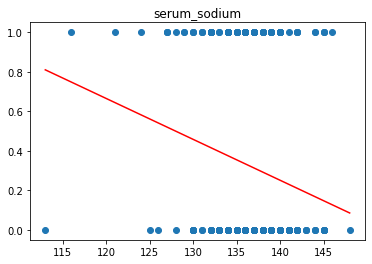

Reg Line for time: 0.7346825076290924 - 0.003175261111766934 x**1


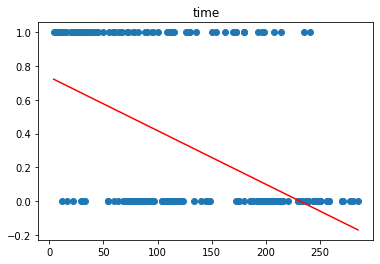

In [35]:
for x in cols_num:
    plot_regression(df, x)

In [36]:
coefs = get_coefs(df, cols)

# get all coeficients and sort by their beta1. bet0 is the intercept
pd.DataFrame(coefs, columns=['feature', 'beta0', 'beta1']).sort_values(by='beta1', ascending=False)

#print(coefs)
#tabulate(coefs, tablefmt='html', headers = ['Feature','$\\beta_{0}$', '$\\beta_{1}$'])

,feature,beta0,beta1
7,serum_creatinine,0.135637,1.330339e-01
5,high_blood_pressure,0.293814,7.761414e-02
1,anaemia,0.294118,6.247150e-02
0,age,-0.285802,9.975892e-03
2,creatinine_phosphokinase,0.303479,3.023443e-05
6,platelets,0.382951,-2.349673e-07
3,diabetes,0.321839,-1.839080e-03
11,time,0.734683,-3.175261e-03
9,sex,0.323810,-4.221895e-03
4,ejection_fraction,0.725299,-1.061424e-02


### Transforms

I'm going to copy the original dataset and convert the categorical variables into pandas categories

In [37]:
df_new = df.copy()

df_new.DEATH_EVENT = pd.Categorical(df_new['DEATH_EVENT'])
df_new.high_blood_pressure = pd.Categorical(df_new.high_blood_pressure)
df_new.sex = pd.Categorical(df_new.sex)
df_new.smoking = pd.Categorical(df_new.smoking)

### Modeling

Now I can start modeling, I'm going to do subtractive modeling and then add in some interaction terms. Lets split into TEST and TRAIN datasets first

In [51]:
# Creating a dataframe with 75%
train = df.sample(frac = 0.80).copy()
  
# Creating dataframe with rest of the 25% values
test = df.drop(train.index)

In [52]:
formula1 = 'DEATH_EVENT ~ age + anaemia + creatinine_phosphokinase + diabetes + ejection_fraction + high_blood_pressure + platelets + serum_creatinine + serum_sodium + sex + smoking + time'
model1 = helper.logistic_regression(formula1, data = train)
helper.simple_describe_lgr(model1)

Coefficients</strong,,Value</strong
,$\beta_{0}$,0.00
age,$\beta_{1}$,0.04
anaemia,$\beta_{2}$,0.00
creatinine_phosphokinase,$\beta_{3}$,0.00
diabetes,$\beta_{4}$,0.00
ejection_fraction,$\beta_{5}$,-0.07
high_blood_pressure,$\beta_{6}$,-0.00
platelets,$\beta_{7}$,-0.00
serum_creatinine,$\beta_{8}$,0.00
serum_sodium,$\beta_{9}$,0.01


NOTE: I kept getting the error below apparently it has to do with Scipy and Sklearn not playing nice. I just keep restarting kernel and usually I can get it to work.

AttributeError: 'str' object has no attribute 'decode'

Lets only add in the features that had highest correlations

In [53]:
df.corr()[abs(df.corr()['DEATH_EVENT']) > 0.1]['DEATH_EVENT']

age                  0.253729
ejection_fraction   -0.268603
serum_creatinine     0.294278
serum_sodium        -0.195204
time                -0.526964
DEATH_EVENT          1.000000
Name: DEATH_EVENT, dtype: float64

In [54]:
formula = 'DEATH_EVENT ~ age + ejection_fraction + serum_creatinine + serum_sodium + time'
model2 = helper.logistic_regression(formula, data = train)
helper.simple_describe_lgr(model2)

Coefficients</strong,,Value</strong
,$\beta_{0}$,0.39
age,$\beta_{1}$,0.04
ejection_fraction,$\beta_{2}$,-0.07
serum_creatinine,$\beta_{3}$,0.42
serum_sodium,$\beta_{4}$,0.00
time,$\beta_{5}$,-0.02
,,
Metrics</strong,Value</strong,
Error (%),15.48,
Efron's $R^2$,0.47,


Lets add in interactions terms with ejection fraction since I think that would change as you get older and also time since that feature seems to have high predictive power

In [55]:
formula = 'DEATH_EVENT ~ age + ejection_fraction + serum_creatinine + time + age:ejection_fraction + time:ejection_fraction'
model3 = helper.logistic_regression(formula, data = train)
helper.simple_describe_lgr(model3)

Coefficients</strong,,Value</strong
,$\beta_{0}$,0.00
age,$\beta_{1}$,0.02
ejection_fraction,$\beta_{2}$,-0.03
serum_creatinine,$\beta_{3}$,0.36
time,$\beta_{4}$,0.02
age:ejection_fraction,$\beta_{5}$,0.00
time:ejection_fraction,$\beta_{6}$,-0.00
,,
Metrics</strong,Value</strong,
Error (%),13.39,


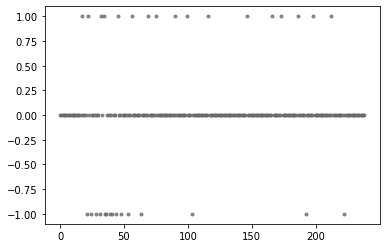

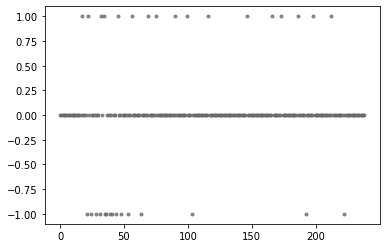

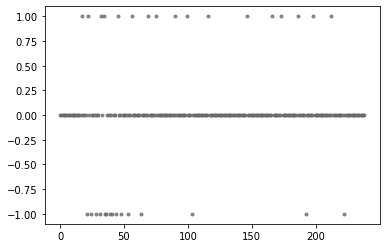

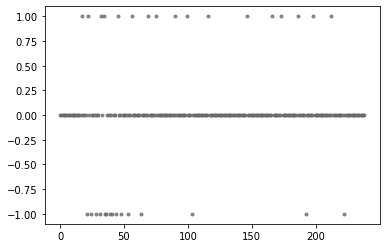

In [56]:
features = ['age','ejection_fraction','serum_creatinine','time']
for i in features:
    fig, ax = plt.subplots()

    #residuals = np.array([r[0] for r in model3["residuals"]])
    residuals = model3["residuals"]
    trials = model3['n']

    variable = 'ejection_fraction'
    keyed_values = sorted(zip(train[variable].values, residuals), key=lambda x: x[ 0])
    ordered_residuals = [x[ 1] for x in keyed_values]

    ax.plot(list(range(trials)), ordered_residuals,'.', color="dimgray", alpha=0.75)

    plt.show()
    plt.close()

Residuals look evenly distrbuted and this looks like a decent model, error is pretty low and R2 isn't too bad. Lets make predictions with it and see the results

### Predictions

In [57]:
# we need to split our features from our target so I can pass them into my model
x = test[['age','ejection_fraction','serum_creatinine','time']].copy()
# add interaction terms
x['age:ejection_fraction'] = x['age'] * x['ejection_fraction']
x['time:ejection_fraction'] = x['time'] * x['ejection_fraction']

# add intercept
x['intercept'] = x['age'] - x['age']

# shift column 'Name' to first position
first_column = x.pop('intercept')
  
# insert column using insert(position,column_name,# first_column) function
x.insert(0, 'intercept', first_column)

# make predictions
preds = model3['model'].predict(x)

# add values back into 
x['y'] = test['DEATH_EVENT']
x['preds'] = preds.tolist()

# predicted True but actually false
FP = x.loc[(x['preds'] == 1) & (x['y'] == 0)].shape[0]
# predicted True and actually true
TP = x.loc[(x['preds'] == 1) & (x['y'] == 1)].shape[0]

# predicted False and actually false
TN = x.loc[(x['preds'] == 0) & (x['y'] == 0)].shape[0]
# predicted False but actually true
FN = x.loc[(x['preds'] == 0) & (x['y'] == 1)].shape[0]

cm = np.array([[f'TN={TN}', f'FP={FP}'], [f'FN={FN}',f'TP={TP}']])

In [58]:
tabulate(cm,tablefmt='html')

TN=36,FP=4
FN=8,TP=12


### Using SciKit Learn

This uses sklearn non modified packages and essential gets the same thing

ref: https://scikit-learn.org/stable/index.html

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix


x = df[['age','ejection_fraction','serum_creatinine','serum_sodium','time']]
y = df['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

print(classification_report(y_test, predictions))
print('matrix:')
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        42
           1       0.68      0.72      0.70        18

    accuracy                           0.82        60
   macro avg       0.78      0.79      0.79        60
weighted avg       0.82      0.82      0.82        60

matrix:
[[36  6]
 [ 5 13]]


My method seems to be close to sklearn so thats good! Part 2 I will remove some of those outliers and see if it helps